# scikit-HEROS: Models With Multiple Datasets Notebook
This notebook is set up as a demonstration for running scikit-HEROS.


***
## Imports:

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import wilcoxon
p_val = 0.05
# Simulating data
np.random.seed(42)
datasets = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4", "Dataset 5", "Dataset 6"]
timepoints = ["T1", "T2", "T3", "T4", "T5", "T6"]
algorithms = ["Algorithm 1", "Algorithm 2"]
subplot_count = len(timepoints)*len(algorithms)

data = []
for dataset in datasets:
    for timepoint in timepoints:
        for algorithm in algorithms:
            # Simulate 100 metric values per timepoint per algorithm per dataset
            metrics = np.random.normal(
                loc=0.8 if algorithm == "Algorithm 1" else 0.75,
                scale=0.05,
                size=100
            )
            for metric in metrics:
                data.append({
                    "Dataset": dataset,
                    "Time Point": timepoint,
                    "Algorithm": algorithm,
                    "Metric": metric
                })

# Convert to DataFrame
df = pd.DataFrame(data)

# Create a combined column for grouping within each dataset
df['Group'] = df['Time Point'] + " | " + df['Algorithm']

custom_palette = [
    "#f0f0f0",  # very light grey
    "#FFCC99",  # light orange
    "#d3d3d3",  # light grey
    "#FFFF99",  # light yellow
    "#b0b0b0",  # light medium grey
    "#99FF99",  # light green
    "#808080",  # medium grey
    "#99CCFF",  # light blue
    "#707070",  # slightly dark grey
    "#9999FF",  # light indego
    "#585858",   # medium dark grey
    "#CC99FF"   # light violet
]
"""
custom_palette = [
    "#f0f8ff",  # lightest blue
    "#f0f0f0",  # very light grey
    "#b3e0ff",  # light sky blue
    "#d3d3d3",  # light grey
    "#80c4e6",  # light medium blue
    "#b0b0b0",  # light medium grey
    "#4da3d1",  # moderate blue
    "#808080",  # medium grey
    "#2692cc",  # slightly darker blue
    "#707070",  # slightly dark grey
    "#1a73a8",  # medium dark blue
    "#585858"   # medium dark grey
]
"""
# Create the boxplot
plt.figure(figsize=(15, 8))
ax = sns.boxplot(
    x="Dataset",
    y="Metric",
    hue="Group",
    data=df,
    dodge=True,
    palette=sns.color_palette(custom_palette),
    showmeans=True,
    meanprops={'marker':'o',
                       'markerfacecolor':'black', 
                       'markeredgecolor':'white',
                       'markersize':'4'}
)
# Add a horizontal dashed line at y = 0
ax.axhline(y=0.5, color='red', linestyle='--', linewidth=1)

# Perform Wilcoxon rank-sum test and annotate significant differences
i = 0
for dataset in datasets:
    j= 0
    for timepoint in timepoints:
        # Get the data for Algorithm 1 and Algorithm 2
        alg1_data = df[(df['Dataset'] == dataset) & (df['Time Point'] == timepoint) & (df['Algorithm'] == "Algorithm 1")]['Metric']
        alg2_data = df[(df['Dataset'] == dataset) & (df['Time Point'] == timepoint) & (df['Algorithm'] == "Algorithm 2")]['Metric']

        # Perform the Wilcoxon rank-sum test
        success = False
        try:
            statistic, p_value = wilcoxon(alg1_data, alg2_data)
            #print('Comparison: '+str(statistic)+ ' '+ str(p_value))
            success = True
        except:
            success = False

        if success and p_value < p_val:
            mean_alg2 = alg2_data.mean()
            ymin, ymax = ax.get_ylim()
            y_coordinate = ymin + (mean_alg2 - ymin) * (ymax - ymin) / (ymax - ymin)

            # Define the minimum and maximum values
            min_value = i - 0.4
            max_value = i + 0.4
            width = max_value - min_value
            boxwidth = width / subplot_count
            
            # Generate n equally spaced values between min_value and max_value
            values = np.linspace(min_value+(boxwidth*1.5), max_value-(boxwidth/2), 6)
            x_coordinate = values[j]
            plt.text(x_coordinate, y_coordinate, "*", ha='center', va='bottom', fontsize=10, color='red')
        j+= 1
    i += 1
print(f"Y-axis range: {ymin} to {ymax}")

# Get and print x tick mark locations
x_ticks = ax.get_xticks()
print("X tick mark locations:", x_ticks)

# Customize the plot
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("Balanced Testing Accuracy", fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title="Time Point | Algorithm", loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()

# Show the plot
plt.show()



In [1]:
import os
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, leaves_list
from sklearn.metrics import classification_report
# If pip installed
#from skheros.heros import HEROS
# If locally run
from src.skheros.heros import HEROS

current_working_directory = os.getcwd()
print(current_working_directory)

/Users/gabe/scikit-heros


***
## Set Up Local Run Parameters


In [2]:
local_save = True
folder_path = './output'
output_name = 'demo'
if not os.path.exists(folder_path):
        os.makedirs(folder_path)
if local_save:
    output_folder = './output'
else:
    output_folder = folder_path

***
# Data

### Load Datasets

In [3]:
df_0 = pd.read_csv('/Users/gabe/scikit-heros/test/datasets/Multiplexer6.csv')
outcome_label_0 = 'class'

df_1 = pd.read_csv('/Users/gabe/scikit-heros/test/datasets/B_gametes_uni_4add_L_1_H_0.4_EDM-2_01.csv')
outcome_label_1 = 'Class'

df_2 = pd.read_csv('/Users/gabe/scikit-heros/test/datasets/D_gametes_2way_epistasis_L_2_H_0.4_EDM-2_01.csv')
outcome_label_2 = 'Class'

print(df_0)
print(df_1)
print(df_2)

    A_0  A_1  R_0  R_1  R_2  R_3  class
0     0    0    0    0    0    0      0
1     0    0    0    0    0    1      0
2     0    0    0    0    1    0      0
3     0    0    0    0    1    1      0
4     0    0    0    1    0    0      0
..  ...  ...  ...  ...  ...  ...    ...
59    1    1    1    0    1    1      1
60    1    1    1    1    0    0      0
61    1    1    1    1    0    1      1
62    1    1    1    1    1    0      0
63    1    1    1    1    1    1      1

[64 rows x 7 columns]
      N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N91  N92  N93  N94  N95  \
0      1   1   0   0   0   0   0   0   1   0  ...    1    1    1    0    1   
1      0   0   0   0   0   0   0   0   0   0  ...    1    0    0    0    0   
2      0   2   0   1   1   0   0   1   0   1  ...    0    0    0    0    1   
3      0   0   0   1   0   0   0   0   0   0  ...    1    1    1    1    0   
4      0   1   0   0   1   1   0   2   0   1  ...    0    2    0    0    0   
...   ..  ..  ..  ..  ..  .. 

*** 

### HEROS Dataset 0

In [4]:
from sklearn.model_selection import train_test_split

X = df_0.drop(outcome_label_0, axis=1)
y = df_0[outcome_label_0]

X_train_0, X_test_0, y_train_0, y_test_0 = train_test_split(X, y, test_size=0.2, random_state=42)
columns = df_0.columns.values.tolist()
print(columns)
feature_names = X_train_0.columns
cat_feat_indexes = list(range(X_train_0.shape[1])) 
X_train_0 = X_train_0.values
y_train_0 = y_train_0.values
X_test_0 = X_test_0.values
y_test_0 = y_test_0.values
print(X)
print(type(X))
ek = None

['A_0', 'A_1', 'R_0', 'R_1', 'R_2', 'R_3', 'class']
    A_0  A_1  R_0  R_1  R_2  R_3
0     0    0    0    0    0    0
1     0    0    0    0    0    1
2     0    0    0    0    1    0
3     0    0    0    0    1    1
4     0    0    0    1    0    0
..  ...  ...  ...  ...  ...  ...
59    1    1    1    0    1    1
60    1    1    1    1    0    0
61    1    1    1    1    0    1
62    1    1    1    1    1    0
63    1    1    1    1    1    1

[64 rows x 6 columns]
<class 'pandas.core.frame.DataFrame'>


In [5]:
heros_null = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = False)

heros_null = heros_null.fit(X_train_0, y_train_0, cat_feat_indexes=cat_feat_indexes, ek=ek)

heros_alt = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = True)
heros_alt = heros_alt.fit(X_train_0, y_train_0, cat_feat_indexes=cat_feat_indexes, ek=ek)

heros_alt1 = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = None)
heros_alt1 = heros_alt1.fit(X_train_0, y_train_0, cat_feat_indexes=cat_feat_indexes, ek=ek)


Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 6
Total Features: 6
Total Instances: 51
Feature Types: [1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [1, 0]
Class Counts: {1: 29, 0: 22}
Class Weights: {1: 0.43137254901960786, 0: 0.5686274509803921}
Majority Class: 1
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf]]
Categorical Feature Values: [[0, 1], [0, 1], [1, 0], [1, 0], [0, 1], [1, 0]]
Average States: 2.0
Rule Specificity Limit: 6
--------------------------------------------------------------------
   Iteration  Pred.Acc.Est.  Total Time  Cover Time  Equality Time  \
0       1000          0.822       0.152         0.0          0.008   

   Match Time  Eval Time  FT Time  Subsume Time  Select Time  Mate Time  \
0       0.018       0.07      0.0         0.013        0.008      0.011   

   Delete Time  Predict Time  
0        0.022         0

In [6]:
top_00 = heros_null.export_model_growth()
top_10 = heros_alt.export_model_growth()
top_20 = heros_alt1.export_model_growth()

In [7]:
from sklearn.metrics import accuracy_score
y_predict_00 = heros_null.predict(X_test_0, top_rule_set = True)
acc_00 = accuracy_score(y_test_0, y_predict_00)

y_predict_10 = heros_alt.predict(X_test_0, top_rule_set = True)
acc_10 = accuracy_score(y_test_0, y_predict_10)

y_predict_20 = heros_alt1.predict(X_test_0, top_rule_set = True)
acc_20 = accuracy_score(y_test_0, y_predict_20)

***

### HEROS Dataset 1

In [8]:
from sklearn.model_selection import train_test_split

X = df_1.drop(outcome_label_1, axis=1)
y = df_1[outcome_label_1]

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)
columns = df_1.columns.values.tolist()
print(columns)
feature_names = X_train_1.columns
cat_feat_indexes = list(range(X_train_1.shape[1])) 
X_train_1 = X_train_1.values
y_train_1 = y_train_1.values
X_test_1 = X_test_1.values
y_test_1 = y_test_1.values
print(X)
print(type(X))
ek = None

['N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33', 'N34', 'N35', 'N36', 'N37', 'N38', 'N39', 'N40', 'N41', 'N42', 'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49', 'N50', 'N51', 'N52', 'N53', 'N54', 'N55', 'N56', 'N57', 'N58', 'N59', 'N60', 'N61', 'N62', 'N63', 'N64', 'N65', 'N66', 'N67', 'N68', 'N69', 'N70', 'N71', 'N72', 'N73', 'N74', 'N75', 'N76', 'N77', 'N78', 'N79', 'N80', 'N81', 'N82', 'N83', 'N84', 'N85', 'N86', 'N87', 'N88', 'N89', 'N90', 'N91', 'N92', 'N93', 'N94', 'N95', 'M0P0', 'M1P0', 'M2P0', 'M3P0', 'Class']
      N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N90  N91  N92  N93  N94  \
0      1   1   0   0   0   0   0   0   1   0  ...    0    1    1    1    0   
1      0   0   0   0   0   0   0   0   0   0  ...    1    1    0    0    0   
2      0   2   0   1   1   0   0   1   0   1  ...    1    0   

In [9]:
heros_null = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = False)

heros_null = heros_null.fit(X_train_1, y_train_1, cat_feat_indexes=cat_feat_indexes, ek=ek)

heros_alt = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = True)
heros_alt = heros_alt.fit(X_train_1, y_train_1, cat_feat_indexes=cat_feat_indexes, ek=ek)

heros_alt1 = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = None)
heros_alt1 = heros_alt1.fit(X_train_1, y_train_1, cat_feat_indexes=cat_feat_indexes, ek=ek)

Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 100
Total Features: 100
Total Instances: 1280
Feature Types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [0, 1]
Class Counts: {0: 651, 1: 629}
Class Weights: {0: 0.49140625000000004, 1: 0.50859375}
Majority Class: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf

In [10]:
top_01 = heros_null.export_model_growth()
top_11 = heros_alt.export_model_growth()
top_21 = heros_alt1.export_model_growth()

In [11]:
from sklearn.metrics import accuracy_score
y_predict_01 = heros_null.predict(X_test_1, top_rule_set = True)
acc_01 = accuracy_score(y_test_1, y_predict_01)

y_predict_11 = heros_alt.predict(X_test_1, top_rule_set = True)
acc_11 = accuracy_score(y_test_1, y_predict_11)

y_predict_21 = heros_alt1.predict(X_test_1, top_rule_set = True)
acc_21 = accuracy_score(y_test_1, y_predict_21)

***

### HEROS Dataset 2

In [12]:
from sklearn.model_selection import train_test_split

X = df_2.drop(outcome_label_2, axis=1)
y = df_2[outcome_label_2]

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, test_size=0.2, random_state=42)
columns = df_2.columns.values.tolist()
print(columns)
feature_names = X_train_2.columns
cat_feat_indexes = list(range(X_train_2.shape[1])) 
X_train_2 = X_train_2.values
y_train_2 = y_train_2.values
X_test_2 = X_test_2.values
y_test_2 = y_test_2.values
print(X)
print(type(X))
ek = None

['N0', 'N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8', 'N9', 'N10', 'N11', 'N12', 'N13', 'N14', 'N15', 'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22', 'N23', 'N24', 'N25', 'N26', 'N27', 'N28', 'N29', 'N30', 'N31', 'N32', 'N33', 'N34', 'N35', 'N36', 'N37', 'N38', 'N39', 'N40', 'N41', 'N42', 'N43', 'N44', 'N45', 'N46', 'N47', 'N48', 'N49', 'N50', 'N51', 'N52', 'N53', 'N54', 'N55', 'N56', 'N57', 'N58', 'N59', 'N60', 'N61', 'N62', 'N63', 'N64', 'N65', 'N66', 'N67', 'N68', 'N69', 'N70', 'N71', 'N72', 'N73', 'N74', 'N75', 'N76', 'N77', 'N78', 'N79', 'N80', 'N81', 'N82', 'N83', 'N84', 'N85', 'N86', 'N87', 'N88', 'N89', 'N90', 'N91', 'N92', 'N93', 'N94', 'N95', 'N96', 'N97', 'M0P0', 'M0P1', 'Class']
      N0  N1  N2  N3  N4  N5  N6  N7  N8  N9  ...  N90  N91  N92  N93  N94  \
0      1   0   0   1   0   0   0   1   0   0  ...    1    0    0    0    1   
1      1   0   0   0   0   1   0   1   0   0  ...    1    0    0    0    1   
2      0   0   0   1   0   1   0   1   0   0  ...    0    0    0

In [13]:
heros_null = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = False)

heros_null = heros_null.fit(X_train_2, y_train_2, cat_feat_indexes=cat_feat_indexes, ek=ek)

heros_alt = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = True)
heros_alt = heros_alt.fit(X_train_2, y_train_2, cat_feat_indexes=cat_feat_indexes, ek=ek)

heros_alt1 = HEROS(outcome_type='class',iterations=10000, pop_size=500, cross_prob=0.8, mut_prob=0.04, nu=1, beta=0.2, theta_sel=0.5,
              fitness_function='pareto',subsumption='both', use_ek=False, rsl=None, feat_track='end', model_iterations=100,
              model_pop_size=100, new_gen=1.0, merge_prob=0.1, pop_init_type=None, compaction='sub',
              track_performance=1000,random_state=42, verbose=True, prob = None)
heros_alt1 = heros_alt1.fit(X_train_2, y_train_2, cat_feat_indexes=cat_feat_indexes, ek=ek)

Data Manage Summary: ------------------------------------------------
Number of quantitative features: 0
Number of categorical features: 100
Total Features: 100
Total Instances: 1280
Feature Types: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
Missing Values: 0
Classes: [0, 1]
Class Counts: {0: 651, 1: 629}
Class Weights: {0: 0.49140625000000004, 1: 0.50859375}
Majority Class: 0
Quantiative Feature Range: [[inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf], [inf, -inf

In [14]:
top_02 = heros_null.export_model_growth()
top_12 = heros_alt.export_model_growth()
top_22 = heros_alt1.export_model_growth()

In [15]:
from sklearn.metrics import accuracy_score
y_predict_02 = heros_null.predict(X_test_2, top_rule_set = True)
acc_02 = accuracy_score(y_test_2, y_predict_02)

y_predict_12 = heros_alt.predict(X_test_2, top_rule_set = True)
acc_12 = accuracy_score(y_test_2, y_predict_12)

y_predict_22 = heros_alt1.predict(X_test_2, top_rule_set = True)
acc_22 = accuracy_score(y_test_2, y_predict_22)

***

# Plot

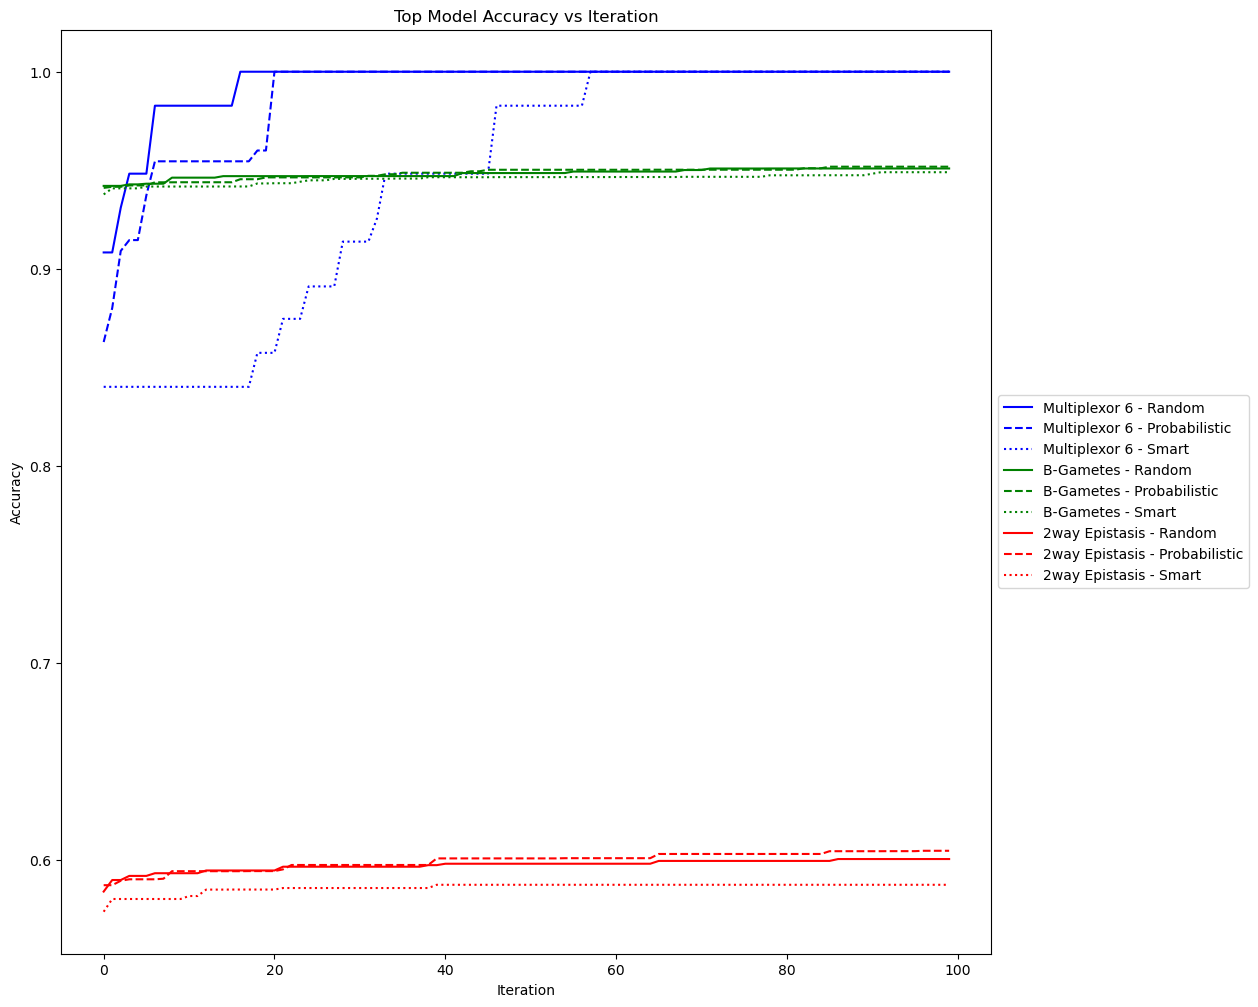

In [16]:

plt.figure(figsize=(12, 12))
# Create the plot with differentiated line styles and colors
plt.plot(top_00.index, top_00["Accuracy"], label="Multiplexor 6 - Random", linestyle='-', color='blue')
plt.plot(top_10.index, top_10["Accuracy"], label="Multiplexor 6 - Probabilistic", linestyle='--', color='blue')
plt.plot(top_20.index, top_20["Accuracy"], label="Multiplexor 6 - Smart", linestyle=':', color='blue')

plt.plot(top_01.index, top_01["Accuracy"], label="B-Gametes - Random", linestyle='-', color='green')
plt.plot(top_11.index, top_11["Accuracy"], label="B-Gametes - Probabilistic", linestyle='--', color='green')
plt.plot(top_21.index, top_21["Accuracy"], label="B-Gametes - Smart", linestyle=':', color='green')

plt.plot(top_02.index, top_02["Accuracy"], label="2way Epistasis - Random", linestyle='-', color='red')
plt.plot(top_12.index, top_12["Accuracy"], label="2way Epistasis - Probabilistic", linestyle='--', color='red')
plt.plot(top_22.index, top_22["Accuracy"], label="2way Epistasis - Smart", linestyle=':', color='red')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel("Accuracy")
plt.title('Top Model Accuracy vs Iteration')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

# Show plot
plt.show()


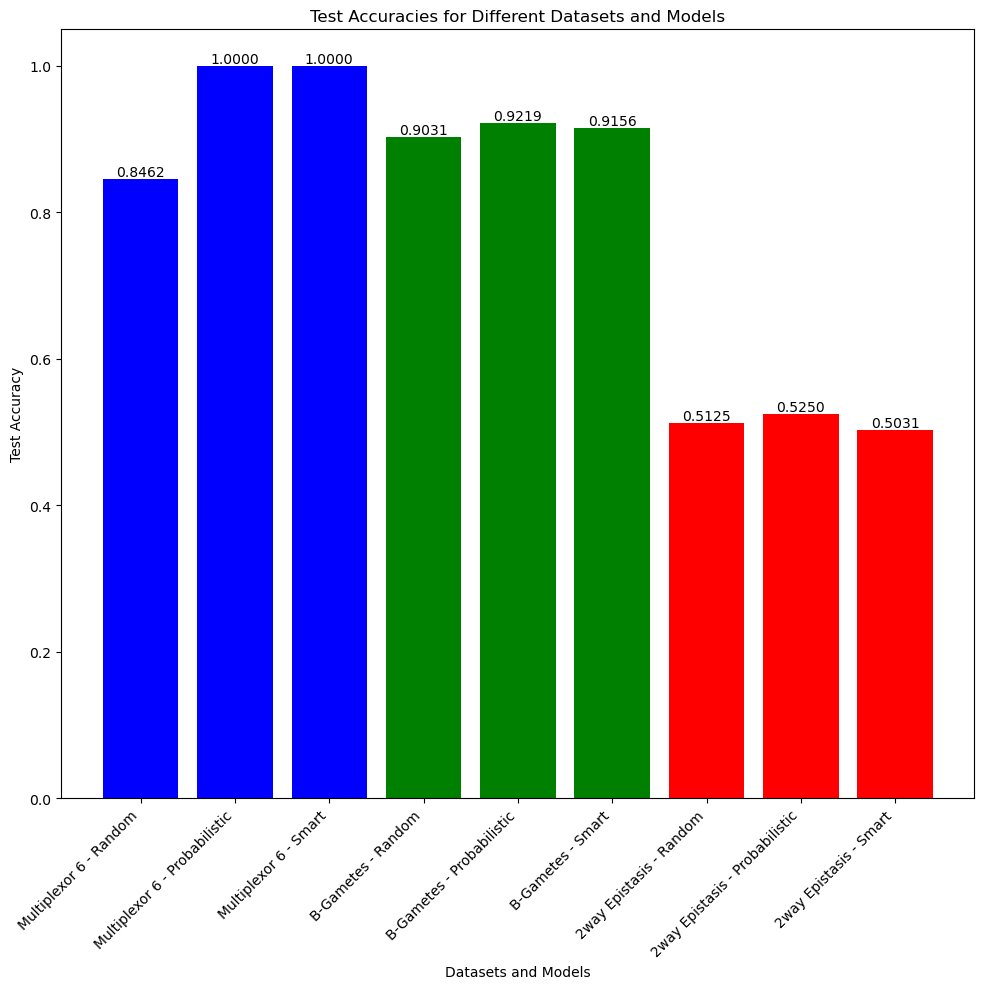

In [17]:
import matplotlib.pyplot as plt

# Define labels for each dataset and model
labels = [
    "Multiplexor 6 - Random", "Multiplexor 6 - Probabilistic", "Multiplexor 6 - Smart",
    "B-Gametes - Random", "B-Gametes - Probabilistic", "B-Gametes - Smart",
    "2way Epistasis - Random", "2way Epistasis - Probabilistic", "2way Epistasis - Smart"
]

# Corresponding test accuracy values for each dataset and model
test_accuracies = [
    acc_00, acc_10, acc_20,
    acc_01, acc_11, acc_21,
    acc_02, acc_12, acc_22
]

# Create a bar chart for test accuracies
plt.figure(figsize=(10, 10))
bars = plt.bar(labels, test_accuracies, color=['blue', 'blue', 'blue', 'green', 'green', 'green', 'red', 'red', 'red'])

# Add labels and title
plt.xlabel("Datasets and Models")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracies for Different Datasets and Models")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

for bar, accuracy in zip(bars, test_accuracies):
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X position of the text
        bar.get_height(),  # Y position of the text (top of the bar)
        f"{accuracy:.4f}",  # Format the text with two decimal places
        ha='center',  # Center the text horizontally
        va='bottom'   # Position text just above the bar
    )

# Show plot
plt.tight_layout()  # Adjust layout to fit labels
plt.show()
